<a href="https://colab.research.google.com/github/iffyaiyan/news_data/blob/main/news_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# authenticating the user
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1eB0b8RnLWG8tW43zQDnSk-YMD_pcl-Dk/view?usp=sharing'
# to get the id part of the file 
id = link.split("/")[-2] 
  
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('News_Category_Dataset_v2.json') 

In this kernel, I am going to discuss about Content based recommendation using News category dataset. The goal is to recommend news articles which are similar to the already read article by using attributes like article headline, category, author and publishing date.

The Dataset has the followings columns
- category
- Headline
- Authors
- Link
- Short Description
- Date


### Importing the Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from string import punctuation
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer


from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
import collections

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Going through the Data

In [ ]:
# Reading the data
df = pd.read_json('News_Category_Dataset_v2.json', lines = True)
df.head()

category  ...       date
0          CRIME  ... 2018-05-26
1  ENTERTAINMENT  ... 2018-05-26
2  ENTERTAINMENT  ... 2018-05-26
3  ENTERTAINMENT  ... 2018-05-26
4  ENTERTAINMENT  ... 2018-05-26

[5 rows x 6 columns]

In [ ]:
# Finding the shape of the data
df.shape

(200853, 6)

The dataset has 200853 rows and 6 columns

In [ ]:
# GEtting more info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


From above we can see that there is no any missing value, further we can even check by using the code of the below cell

In [ ]:
df.isnull().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

So now its clear that there is no any missing values

In [ ]:
# Describing the data
df.describe()

category        headline  ... short_description                 date
count     200853          200853  ...            200853               200853
unique        41          199344  ...            178353                 2309
top     POLITICS  Sunday Roundup  ...                    2013-01-17 00:00:00
freq       32739              90  ...             19712                  100
first        NaN             NaN  ...               NaN  2012-01-28 00:00:00
last         NaN             NaN  ...               NaN  2018-05-26 00:00:00

[6 rows x 6 columns]

In [ ]:
# Counting the number of unique category and then priting them
print(df['category'].nunique())
df['category'].unique()

41


array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

There are 41 unique category in the datasets

In [ ]:
# Printing the number of words in each category
print(df.groupby('category').size())


category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          2579
dtype: 

In [ ]:
# Trying to know about the year and month from the Data
import datetime
df['year'] = pd.DatetimeIndex(df['date']).year
df.head()

category  ...  year
0          CRIME  ...  2018
1  ENTERTAINMENT  ...  2018
2  ENTERTAINMENT  ...  2018
3  ENTERTAINMENT  ...  2018
4  ENTERTAINMENT  ...  2018

[5 rows x 7 columns]

In [ ]:
# Trying to add the month details
df['month'] = pd.DatetimeIndex(df['date']).month
df.head()

category  ... month
0          CRIME  ...     5
1  ENTERTAINMENT  ...     5
2  ENTERTAINMENT  ...     5
3  ENTERTAINMENT  ...     5
4  ENTERTAINMENT  ...     5

[5 rows x 8 columns]

In [ ]:
# Lets find out the unique values of months and year in the dataset
print('These data are of {} years'.format(df['year'].nunique()))
print("So below is the name of the year")
print(df['year'].unique())

print('These data are of {} months'.format(df['month'].nunique()))
print("So below is the name of the months")
print(df['month'].unique())

These data are of 7 years
So below is the name of the year
[2018 2017 2016 2015 2014 2013 2012]
These data are of 12 months
So below is the name of the months
[ 5  4  3  2  1 12 11 10  9  8  7  6]


As we can see that there are many category name which are interlinked so its better to combine them

* 'ARTS' || 'ARTS & CULTURE' || 'CULTURE & ARTS'
* 'STYLE & BEAUTY' || 'STYLE'
* 'EDUCATION' || 'COLLEGE'
* 'WORLDPOST' || 'THE WORLDPOST'
* 'PARENTS' || 'PARENTING'
* 'TASTE' || 'FOOD & DRINK'

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Defining a function to merge the similar category name

def category_merge(x):
    
    if x == 'THE WORLDPOST':
        return 'WORLDPOST'
    elif x == 'TASTE':
        return 'FOOD & DRINK'
    elif x == 'STYLE':
        return 'STYLE & BEAUTY'
    elif x == 'PARENTING':
        return 'PARENTS'
    elif x == 'COLLEGE':
        return 'EDUCATION'
    elif x == 'ARTS' or x == 'CULTURE & ARTS':
        return 'ARTS & CULTURE'
    
    else:
        return x
    
df['category'] = df['category'].apply(category_merge)
le = LabelEncoder()
data_labels = le.fit_transform(df['category'])
list(le.classes_)

['ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COMEDY',
 'CRIME',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE & BEAUTY',
 'TECH',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST']

In [ ]:
# Counting the number of unique author and then printing the name
print(df['authors'].nunique())
df['authors'].unique()

27993


array(['Melissa Jeltsen', 'Andy McDonald', 'Ron Dicker', ...,
       'Courtney Garcia, Contributor\nI tell stories and drink wine.',
       'Mateo Gutierrez, Contributor\nArtist',
       'John Giacobbi, Contributor\nTales from the Interweb by The Web Sheriff'],
      dtype=object)

There is approx 28k authors writing the news headlines


In [ ]:
# Removing the space between the authors name and writing them in simplified way
df['authors'] = df['authors'].apply(lambda x: x.split(',')[0])
df['authors'] = df['authors'].str.replace(' ', '', regex=False)
df['authors'].unique()

array(['MelissaJeltsen', 'AndyMcDonald', 'RonDicker', ..., 'SarahCosta',
       'MateoGutierrez', 'JohnGiacobbi'], dtype=object)

Now we have removed the spaces between  the name and surname 

In [ ]:
# Counting the contributions of different authors 
print(df.groupby('authors').size())


authors
                      36620
"SethEliot"Santoro        1
#DoctorsSpeakOut          1
'TheKochSisters'          1
*                         1
                      ...  
ÉloïseBouton              1
レシピブログ通信                  1
吉野ゆりえ                     1
渋谷健司                      1
딘베이커                      8
Length: 23974, dtype: int64


## Visualization of the Data

In [ ]:
# Plotting to see the yearwise writing and publishing of the news

labels = df['year'].value_counts().index
values = df['year'].value_counts().values

colors = df['year']

fig = go.Figure(data = [go.Pie(labels = labels, values = values, textinfo = "label+percent",
                               marker = dict(colors = colors))])
fig.show()

From the above we can see that in 2013 the max number of news headlines were published followed by 2014 and 2016

In [ ]:
# Plotting to see the monthwise pattern of writing and publishing of the news

labels = df['month'].value_counts().index
values = df['month'].value_counts().values

colors = df['month']

fig = go.Figure(data = [go.Pie(labels = labels, values = values, textinfo = "label+percent",
                               marker = dict(colors = colors))])
fig.show()

Compare to the other months, March (3), April (4) and May (5) seems to be more busy months in terms of publishing the news headlines, so more headlines means this months have more news coverage too

In [ ]:
labels = df['category'].value_counts().index
values = df['category'].value_counts().values

colors = df['category']

fig = go.Figure(data = [go.Pie(labels = labels, values = values, textinfo = "label+percent",
                               marker = dict(colors = colors), pull=[0, 0, 0.2, 0]
       )])
fig.show()

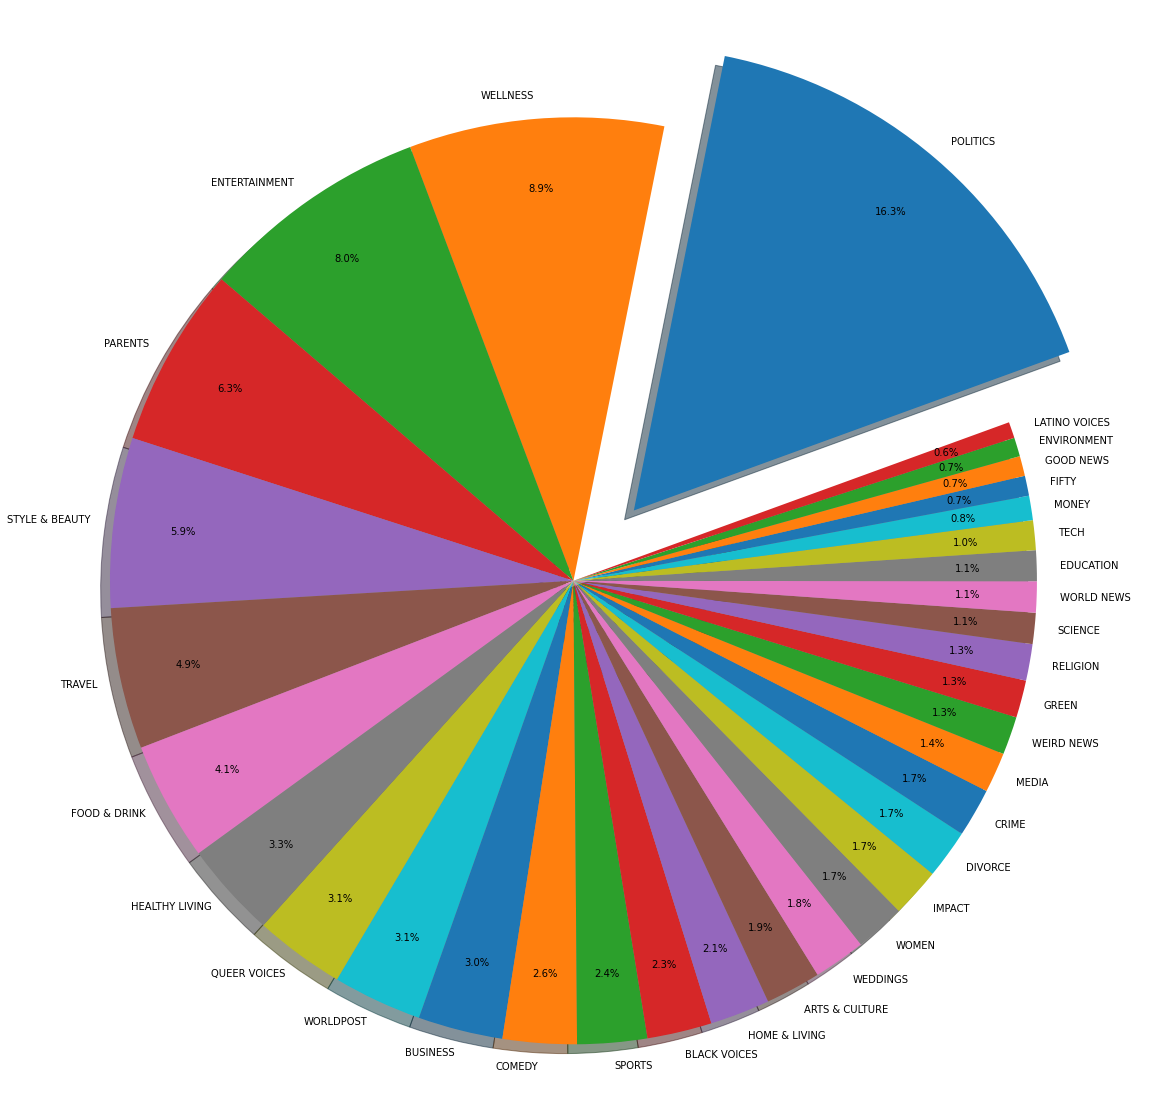

In [ ]:
# Visaulizing the same plot but without using the Ploty

plt.figure(figsize=(20,20))
sizes = df['category'].value_counts().values
labels = df['category'].value_counts().index
plt.pie(sizes, labels=labels, autopct='%.1f%%',
        shadow=True, pctdistance=0.85, labeldistance=1.05, startangle=20, 
        explode = [0 if i > 0 else 0.2 for i in range(len(sizes))])
plt.axis('equal')
plt.show()

From the above pie-chart it has been clear that most of maximum news coverage priority has been given to Politics followed by Wellness, Entertainement, Parenting, Style & Beauty

Ironically Education, Tech, Environment and Science has been given the least voice

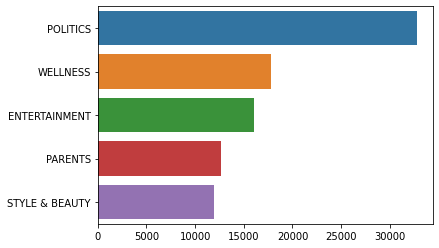

In [ ]:
sns.barplot(y=df['category'].value_counts()[:5].index, x=df['category'].value_counts()[:5].values, orient='h')

## Data Preprocessing


Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:

* Tokenizing the string
* Lowercasing
* Removing stop words and punctuation
* Stemming
* Lemmatization

In [ ]:
data_labels

array([ 4,  7,  7, ..., 24, 24, 24])

In [ ]:
df['target'] = data_labels
df.head()

category  ... target
0          CRIME  ...      4
1  ENTERTAINMENT  ...      7
2  ENTERTAINMENT  ...      7
3  ENTERTAINMENT  ...      7
4  ENTERTAINMENT  ...      7

[5 rows x 9 columns]

In [ ]:
df['target'].unique()

array([ 4,  7, 32, 15, 20, 29,  1, 31,  3, 21, 24,  2, 27, 17, 26, 22, 23,
       16,  6, 19,  0, 25, 12, 10, 13, 33, 11,  9, 30, 14,  5, 28, 18,  8])

### Cleaning the text

In [ ]:
# Defining function to clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
# Applying clean text function on short_description to clean the text

df['short_description'] = df['short_description'].apply(lambda x: clean_text(x))

In [ ]:
df.head()

category  ... target
0          CRIME  ...      4
1  ENTERTAINMENT  ...      7
2  ENTERTAINMENT  ...      7
3  ENTERTAINMENT  ...      7
4  ENTERTAINMENT  ...      7

[5 rows x 9 columns]

Plotting the WordCloud

**Word cloud** is a technique for visualising frequent words in a text where the size of the words represents their frequency

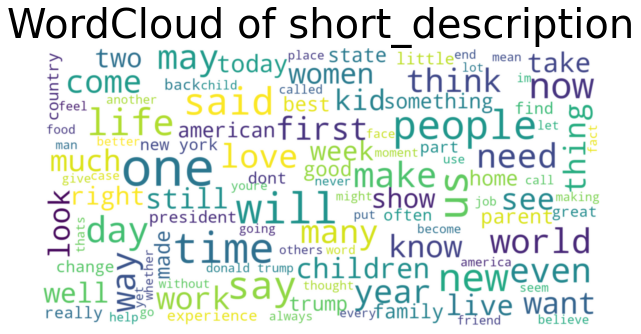

In [ ]:
word_cloud = WordCloud(
                       width=1600,
                       height=800,
                       #colormap='PuRd', 
                       margin=0,
                       max_words=500, # Maximum numbers of words we want to see 
                        # Minimum numbers of letters of each word to be part of the cloud
                       max_font_size=150, min_font_size=30,  # Font size range
                       background_color="white").generate(" ".join(df['short_description']))

plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('WordCloud of short_description', fontsize = 40)
plt.axis("off")
plt.show()

## Tokenizing

**What is Tokenization?**
A token is a piece of a whole, so a word is a token in a sentence, and a sentence is a token in a paragraph. Tokenization is the process of splitting a string into a list of tokens.



In [ ]:
print()
text = "I love you, don't you"

# instantiate tokenizer class
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ", text)
print("Tokenization by whitespace: ", tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer: ", tokenizer2.tokenize(text))
print("Tokenization by punctuation: ", tokenizer3.tokenize(text))
print("Tokenization by regular expression: ", tokenizer4.tokenize(text))


Example Text:  I love you, don't you
Tokenization by whitespace:  ['I', 'love', 'you,', "don't", 'you']
Tokenization by words using Treebank Word Tokenizer:  ['I', 'love', 'you', ',', 'do', "n't", 'you']
Tokenization by punctuation:  ['I', 'love', 'you', ',', 'don', "'", 't', 'you']
Tokenization by regular expression:  ['I', 'love', 'you', 'don', 't', 'you']


In [ ]:
# instantiate tokenizer class
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# Tokenizing the trainig set
df['short_description'] = df['short_description'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
print()
print('Tokenized string:')
df['short_description'].head()


Tokenized string:


0    [she, left, her, husband, he, killed, their, c...
1                       [of, course, it, has, a, song]
2    [the, actor, and, his, longtime, girlfriend, a...
3    [the, actor, gives, dems, an, asskicking, for,...
4    [the, dietland, actress, said, using, the, bag...
Name: short_description, dtype: object

### Stopwords

The next step is to remove stop words. Stop words are words that don't add significant meaning to the text.

In [ ]:
# Downloading the nltk stopwords extension
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Definig a function to remove the stopwords

def remove_stopwords(text):
    
    words = [word for word in text if word not in stopwords.words('english')]
    return words

In [ ]:
# Removing the stopwords 

df['short_description'] = df['short_description'].apply(lambda x: remove_stopwords(x))

In [ ]:
df.head()

category  ... target
0          CRIME  ...      4
1  ENTERTAINMENT  ...      7
2  ENTERTAINMENT  ...      7
3  ENTERTAINMENT  ...      7
4  ENTERTAINMENT  ...      7

[5 rows x 9 columns]

### Normalizing the Tokens


In [ ]:
# Downloading the nltk wordnet extension

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Stemming and Lemmatization examples

text = "How is the Josh"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer 
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  how is the josh
Lemmatizing the sentence:  How is the Josh


In [ ]:
# After preprocessing, the text format
def combine_text(list_of_text):
    
    combined_text = ' '.join(list_of_text)
    return combined_text

df['short_description'] = df['short_description'].apply(lambda x : combine_text(x))
df.head()

category  ... target
0          CRIME  ...      4
1  ENTERTAINMENT  ...      7
2  ENTERTAINMENT  ...      7
3  ENTERTAINMENT  ...      7
4  ENTERTAINMENT  ...      7

[5 rows x 9 columns]

In [ ]:
# text preprocessing function
def text_preprocessing(text):
   
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [word for word in tokenized_text if word not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

### Transforming of tokens to Vector

In [ ]:
# CountVectorizer can do all the above task of preprocessing, tokenization, and stop words removal
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df['short_description'])
    
# Keeping only non-zero elements to preserve spaces
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


In [ ]:
# Defining the model
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
# Training and transforming 
train_tfidf = tfidf.fit_transform(df['short_description'])


### Building the Final Classification Model

In [ ]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "MultinimialNB": MultinomialNB()
}

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df['target'].values.reshape(-1,1))
scaler.transform(df['target'].values.reshape(-1,1))

array([[-1.48810558],
       [-1.16786774],
       [-1.16786774],
       ...,
       [ 0.64681339],
       [ 0.64681339],
       [ 0.64681339]])

In [ ]:
# Wow our scores are getting even high scores even when applying cross validation.
# Lets apply the Classifiers 1st on Countvectoizers
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(train_vectors, df['target'])
    training_score = cross_val_score(classifier, train_vectors, df['target'], cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

In [ ]:
# Wow our scores are getting even high scores even when applying cross validation.
# Lets apply the Classifiers 1st on Countvectoizers
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(train_vectors, df['target'])
    training_score = cross_val_score(classifier, train_vectors, df['target'], cv=5)

In [ ]:
# Fitting a simple Naive Bayes on TFIDF
from sklearn import model_selection
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, df["target"], cv=5, scoring="f1")
scores

In [ ]:
clf_NB_TFIDF.fit(train_tfidf, df["target"])

**Conclusion**
Content based recommendation is based on similarity among users/items obtained through their attributes. It uses the additional information(meta data) about the users or items i.e. it relies on what kind of content is already available. This meta data could be user's demograpic information like age, gender, job, location, skillsets etc. Similarly for items it can be item name, specifications, category, registration date etc.

So the core idea was to recommend items by finding similar items/users to the concerned item/user based on their attributes.